In [0]:
 # Install keras for neural network model
!pip install -q keras
import keras

# Install Alpha Vantage
! pip install alpha_vantage

# Install fixed yahoo finance
! pip install fix_yahoo_finance

# Install technical analysis library
! pip install pyti

# function for using plotly
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

# libraries
import fix_yahoo_finance as fyf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import sklearn.preprocessing
from alpha_vantage.timeseries import TimeSeries
ts=TimeSeries(key='0NQE5NPYNBWUATFT',output_format='pandas')
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from alpha_vantage.foreignexchange import ForeignExchange
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
# standard model
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Activation, LSTM
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
# using Plotly 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
init_notebook_mode(connected=True) 

# technical analysis indicators
import pyti
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.relative_strength_index import relative_strength_index
from pyti.accumulation_distribution import accumulation_distribution as accdis
from pyti.bollinger_bands import percent_b
from pyti.money_flow_index import money_flow_index
from pyti.momentum import momentum 
from pyti.stochastic import percent_d as stoc
from pyti.volatility import volatility
from pyti.on_balance_volume import on_balance_volume

Using TensorFlow backend.


  Running setup.py bdist_wheel for alpha-vantage ... - \ done
  Stored in directory: /root/.cache/pip/wheels/21/9c/02/b7cfae63f7119f4089f229ba1a09ce90fabbaf96199c2890be
Successfully built alpha-vantage


## Italian stocks data  
FTSEMIB italian stock prices downloaded in "selenium_news_and_prices\italiaR\italianStocks.csv".

In [0]:
# read csv file 
from google.colab import files
uploaded = files.upload()

Saving italianStocks.csv to italianStocks.csv


In [0]:
import io
italian_stocks = pd.read_csv(io.StringIO(uploaded['italianStocks.csv'].decode('utf-8')))
print(italian_stocks.shape)
print(italian_stocks.head())
print('\nList of stocks:',italian_stocks.id.unique())

(165167, 8)
   Open  High   Low  Close      Volume  Adjusted        Date      id
0  4.04  4.16  3.79   3.79   6390000.0  2.017555  2000-01-03  A2A.MI
1  3.83  3.90  3.60   3.68  10424000.0  1.958998  2000-01-04  A2A.MI
2  3.48  3.67  3.38   3.65  11445000.0  1.943028  2000-01-05  A2A.MI
3  3.62  3.77  3.59   3.77   5027000.0  2.006908  2000-01-06  A2A.MI
4  3.85  3.98  3.75   3.86   7574000.0  2.054819  2000-01-07  A2A.MI

List of stocks: ['A2A.MI' 'ATL.MI' 'AZM.MI' 'BGN.MI' 'BMED.MI' 'BAMI.MI' 'BPE.MI' 'BRE.MI'
 'BZU.MI' 'CPR.MI' 'CNHI.MI' 'ENEL.MI' 'ENI.MI' 'EXO.MI' 'RACE.MI'
 'FCA.MI' 'FBK.MI' 'G.MI' 'ISP.MI' 'IG.MI' 'LDO.MI' 'LUX.MI' 'MS.MI'
 'MONC.MI' 'PST.MI' 'PRY.MI' 'REC.MI' 'SPM.MI' 'SFER.MI' 'SRG.MI' 'STM.MI'
 'TIT.MI' 'TEN.MI' 'TRN.MI' 'UBI.MI' 'UCG.MI' 'UNI.MI' 'US.MI' 'YNAP.MI']


## Backtesting portfolio of stocks  
Using codes for Yahoo Finance (see list in the previous cell), one or multiple codes are allowed.  
Financial series and features are built into the function, just enter the codes.  
The function returns modelling/backtesting for each stock and then aggregates them into a portfolio.

In [0]:
def trade_portfolio(stocks, price,variables, include_dailyReturn, onehot_features, lookback_window, target_window, train_test_split,epochs):
  
  # list storing portfolio returns for each stock
  df=pd.DataFrame()
  df2=pd.DataFrame()
  df3=pd.DataFrame(index=['Accuracy','TotalReturn','AnnualizedReturn','StandardDeviation','SharpeRatio'])

  # loop through all the stocks
  for stock in stocks:
        print('\n###################################################################')
        print('################## ',stock)
        print('n###################################################################')
        # market prices from yahoo finance
        print('\nDownloading',stock)
#         historical prices uploaded above
        prices=italian_stocks.loc[italian_stocks['id']==stock]             # get stock prices from csv file uploaded above
        prices=prices.set_index(pd.DatetimeIndex(prices['Date']))
        prices=prices.drop(['Close','id','Date'],axis=1)
        prices.columns=['Open','High','Low','Volume','Close']
        prices['DailyReturn']=prices['Close'].pct_change()
#         # historical prices from fix_yahoo_finance
#         prices=fyf.download(stock)
#         prices=prices.drop(['Close','Volume'],axis=1)
#         prices.columns=['Open','High','Low','Close']
#         prices['DailyReturn']=prices['Close'].pct_change()
        
        # other features (technical indicators)
#         prices['ema30']=ema(prices['Close'],30)
#         prices['ema60']=ema(prices['Close'],60)
#         prices['ema120']=ema(prices['Close'],120)
#         prices['ema250']=ema(prices['Close'],250)
#         prices['emaa']=(prices['ema30']-prices['ema60'])/prices['ema60']
#         prices['emab']=(prices['ema60']-prices['ema120'])/prices['ema120']
#         prices['emac']=(prices['ema120']-prices['ema250'])/prices['ema250']
#         prices['rsi']=relative_strength_index(prices['Close'],60)/100                       # short(14) or long(60) period
#         prices['rsi_categorical']=pd.cut(prices['rsi'],[0,40,60,100])   # divide rsi into groups
#         #prices['accdis']=accdis(prices['Close'],prices['High'],prices['Low'],prices['Volume'])
#         prices['bollinger_percent']=percent_b(prices['Close'],period=10)
#         prices['bollinger_percent_categorical']=pd.cut(prices['bollinger_percent'],[0,20,50,80,100])   # divide indicator into groups (as categorical type) 
#         prices['bollinger_percent']=prices['bollinger_percent'].pct_change()
        prices['mfi']=money_flow_index(prices['Close'],prices['High'],prices['Low'],prices['Volume'],period=20)   # short(20) or long(50) period
        prices['mfi_categorical']=pd.cut(prices['mfi'],[0,40,50,60,100])                                 # divide indicator into groups (as categorical type)
#         prices['mfi']=prices['mfi'].pct_change()
#         prices['stochastic']=stoc(prices['Close'],30)
#         prices['obv']=on_balance_volume(prices['Close'],prices['Volume'])
#         prices['obv']=prices['obv'].pct_change()  
#         prices['hurst']=prices['Close'].rolling(400).apply(hurst)
#         prices['hurst']=prices['hurst'].pct_change()
          
        # calendar features
        prices['dayofweek']=prices.index.dayofweek
        prices['month']=prices.index.month

        print('prices:',prices.head())

        # select variables from dataframe prices
        data=prices[price+variables+['DailyReturn']] 
        data=data.sort_index(ascending=True)
        # calculate n days return
        days=target_window
        data['NdaysReturn']=data[price].pct_change(days).shift(-days)          # return over the following n days
        # calculate target variable, positive or negative return
        target_variable='NdaysReturn'                                          # select the variable used for the classification
        data['target']=np.where(data[target_variable]>0,1,0)
        data=data.dropna()
        data=data.sort_index(ascending=False)
        print('\ndata:\n',data.head())
        print('\ntarget:',data['target'].value_counts(),'\n')

        # select input features and transform into numpy array
        if include_dailyReturn is True:
          input_features=variables+['DailyReturn']                    # list of features used as input in the model
        else:
          input_features=variables
        print('\ninput_features:',input_features)        
        data_input_features=data[input_features]
        # one-hot encoding, if selected in the function
        data_input_features=pd.get_dummies(data_input_features,columns=onehot_features)
        print('\ninput_features after one-hot encoding:',data_input_features.columns)
        input_data=np.asarray(data_input_features)
        print('\ninput_data array:\n',input_data)
        # select target and transform into numpy
        target=np.asarray(data['target'])
        print('\ntarget:',target)

        # reshape input data into 3D format with lookback window
        window=lookback_window       # lookback window
        pred_window=target_window    # prediction window
        nb_samples=len(input_data)-window-pred_window   # number of samples (windows) that we can extract from the data
        # function to transform into 3D format
        def input_features(nb_samples,LOOKBACK_WINDOW):
         input_list = [np.expand_dims(input_data[i:LOOKBACK_WINDOW+i,:], axis=0) for i in range(nb_samples)]   # lagged daily returns from T-1 to T-window
         input_mat = np.concatenate(input_list, axis=0)
         return(input_mat)
        input_mat=input_features(nb_samples,window)
        print('\ninput_mat shape:',input_mat.shape)
        print('\ninput_mat first sample:\n',input_mat[0])                                  # show first of the samples

        # split data into train / test (remember that dates are inverted)
        split=train_test_split
        train_size=int(len(input_mat)*split)
        test_size=len(input_mat)-train_size
        trainX=input_mat[test_size:len(input_mat)]
        testX=input_mat[0:test_size]

        # create target variable as daily positive or negative return
        trainY=target[test_size:len(input_mat)]
        testY=target[0:test_size]
        print('\ntrainX:',trainX.shape,'trainY:',trainY.shape)
        print('target:',target)
        print('testX:',testX.shape,'testY:',testY.shape,'\n')

        # LSTM model, it requires 3D format of the input layer (samples, timesteps, features)
        # help --> http://aaaquants.com/2017/08/27/machine-learning-lstm-networks/
        bsize=128    #batch size
        nfeatures=input_mat.shape[2]
        # model building 
        model = Sequential()
        model.add(LSTM(30, input_shape=(window,nfeatures)))
        model.add(Dropout(0.5))
        model.add(Dense(1,activation='tanh'))
        model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
#         reduce_lr=ReduceLROnPlateau(monitor='val_acc',factor=0.7,patience=5,min_lr=0.000001)
        model.fit(trainX,trainY,epochs=epochs,batch_size=bsize,validation_split=0.2)
        # accuracy
        score=model.evaluate(testX,testY,batch_size=bsize)
        accuracy=score[1]*100
        print('Accuracy:',accuracy)

        # model predictions on test data
        pred=model.predict_classes(testX)
        pred=pred[:,0]
        pred_longshort=np.where(pred>0,1,-1)

        # returns for backtesting
        r_bt=data.sort_index(ascending=False)['DailyReturn'][0:test_size]    # benchmark market return
        # convert prediction into a series
        pred=pd.Series(pred,index=r_bt.index)                                 
        pred_longshort=pd.Series(pred_longshort,index=r_bt.index)
        print('\nPrediction long:\n',pred.value_counts(),pred.tail())
        print('\nPrediction longshort:\n',pred_longshort.value_counts(),pred_longshort.tail())

        # portfolio returns obtained investing according to the signal produced by the model
        ptf_long=pred*r_bt                           # buy when prediction is 1, out of the market when prediction is 0 
        ptf_longshort=pred_longshort*r_bt            # buy when preditcion is 1, sell short when prediction is 0
        ptf_cumulative=(ptf_long.sort_index(ascending=True)+1).cumprod()-1   # cumulative returns (compounded)
        ptf_cumulative=ptf_cumulative.to_frame()
        ptf_cumulative.columns=['long']
        ptf_cumulative['longshort']=(ptf_longshort.sort_index(ascending=True)+1).cumprod()-1
        ptf_cumulative['market']=(r_bt.sort_index(ascending=True)+1).cumprod()-1
        print('\nPortfolio:\n',ptf_cumulative.head())
          
        # plot portfolio cumulative returns
        # interactive plotly
#         configure_plotly_browser_state()
#         trace_mkt=Scatter(x=ptf_cumulative.index,y=ptf_cumulative['market'],name='market')
#         trace_long=Scatter(x=ptf_cumulative.index,y=ptf_cumulative['long'],name='long')
#         trace_longshort=Scatter(x=ptf_cumulative.index,y=ptf_cumulative['longshort'],name='longshort')
#         layout=dict(title=stock)
#         fig=dict(data=[trace_mkt,trace_long,trace_longshort],layout=layout)
#         iplot(fig)
        # standard plot
        ptf_cumulative.plot(title=stock)
        
        # store returns
        df[stock]=ptf_cumulative['long']
        df2[stock]=ptf_cumulative['market']
        total_return=ptf_cumulative.loc[:,'long'][len(ptf_cumulative)-1]
        df3[stock]=[accuracy,total_return,0,0,0]
  
  results=[]
  results.append(df)
  results.append(df2)
  results.append(df3)
  return(results)
  
 


###################################################################
##################  ATL.MI
n###################################################################

prices:              Open   High    Low     Volume     Close  DailyReturn  mfi  \
Date                                                                     
2003-09-22  12.05  12.18  12.04  4686620.0  6.851015          NaN  NaN   
2003-09-23  12.12  12.31  12.11  2338136.0  6.918791     0.009893  NaN   
2003-09-24  12.26  12.30  12.10  1244278.0  6.845367    -0.010612  NaN   
2003-09-25  12.11  12.17  12.05  1046174.0  6.834070    -0.001650  NaN   
2003-09-26  12.07  12.15  12.01  1013922.0  6.839717     0.000826  NaN   

           mfi_categorical  dayofweek  month  
Date                                          
2003-09-22             NaN          0      9  
2003-09-23             NaN          1      9  
2003-09-24             NaN          2      9  
2003-09-25             NaN          3      9  
2003-09-26             Na

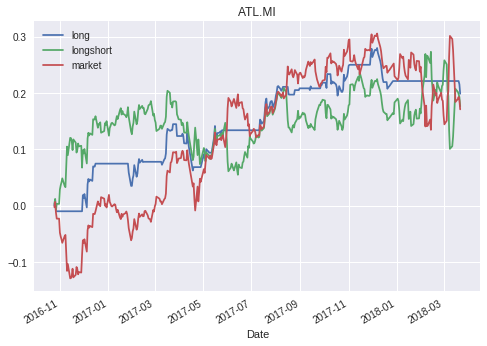

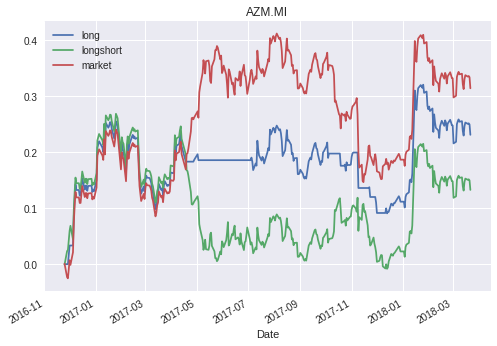

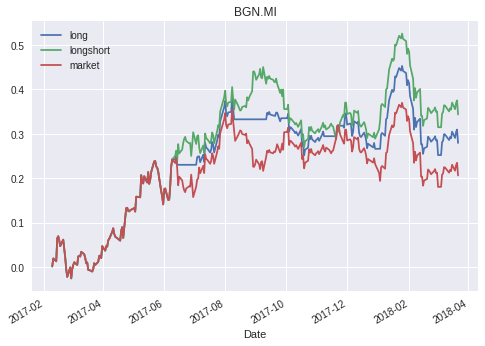

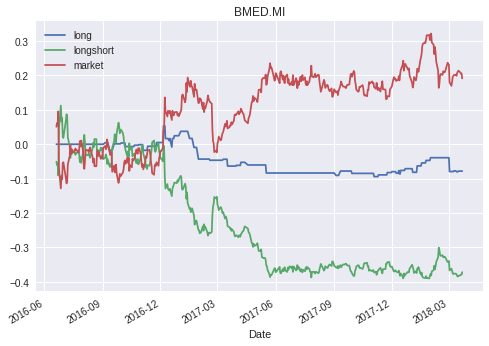

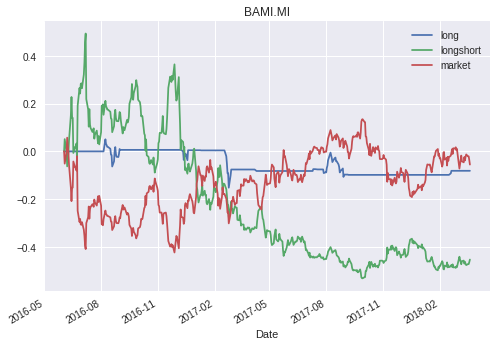

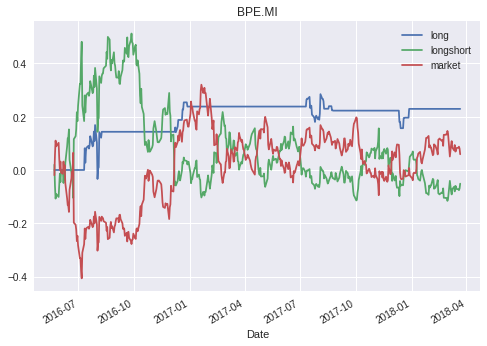

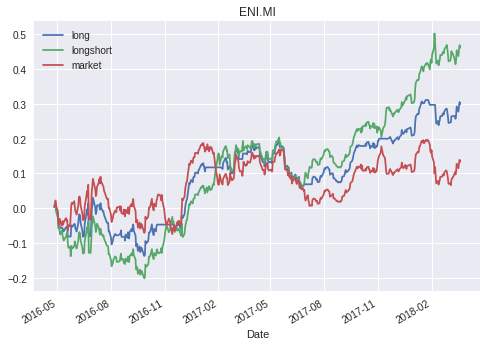

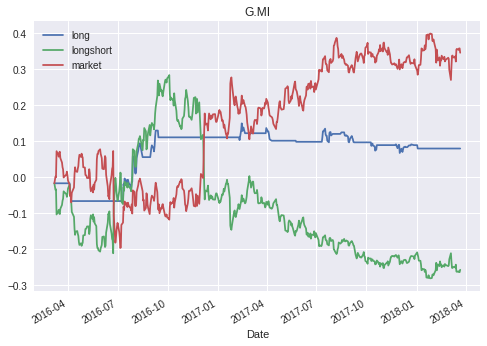

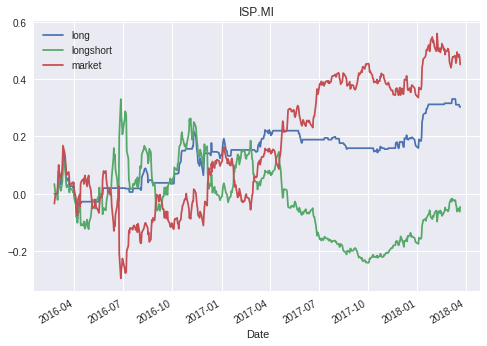

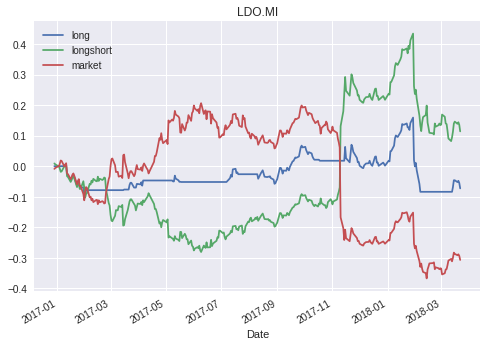

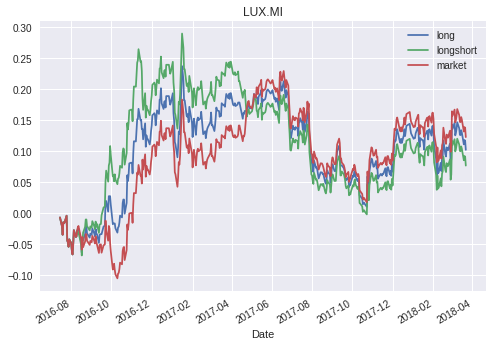

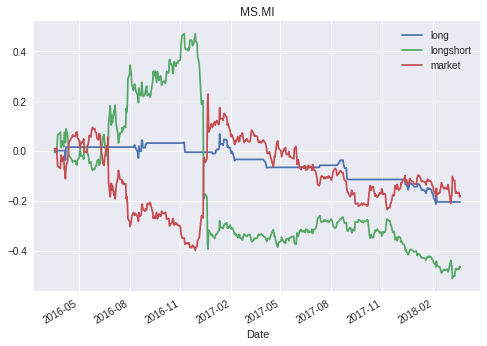

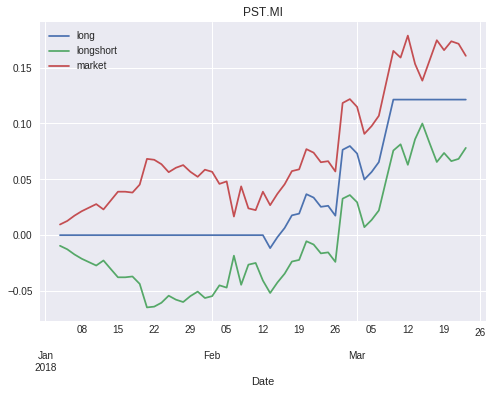

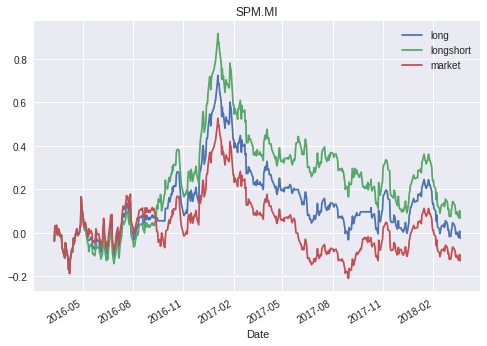

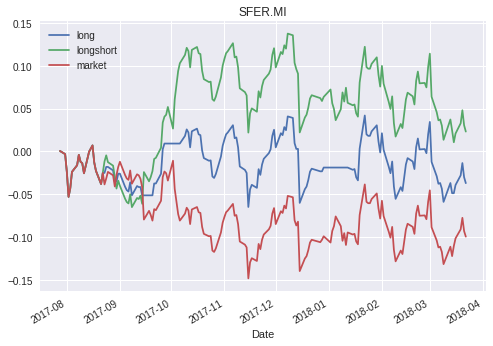

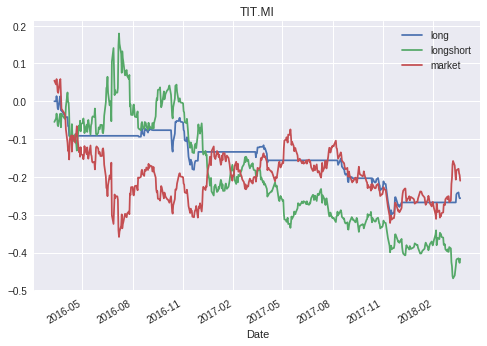

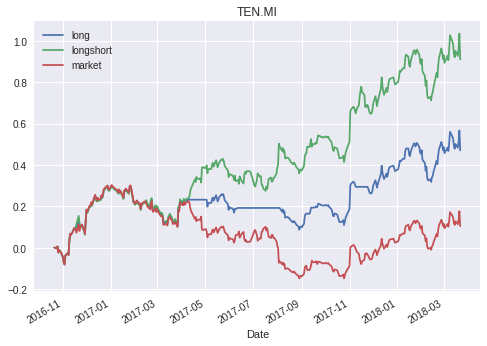

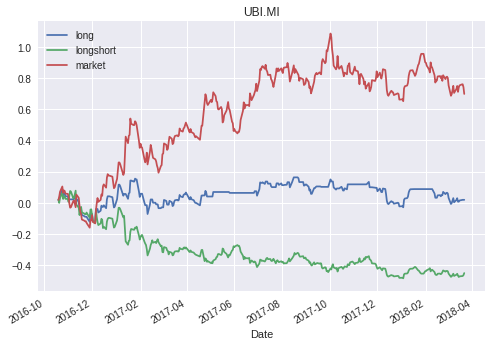

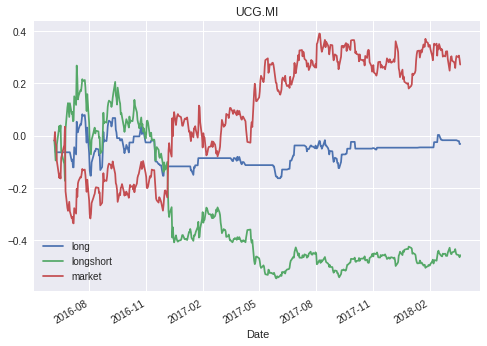

In [0]:
'''
lista=['A2A.MI','ATL.MI','AZM.MI','BGN.MI','BMED.MI',
          'BAMI.MI','BPE.MI','BRE.MI','BZU.MI','CPR.MI',
          'CNHI.MI','ENEL.MI','ENI.MI','EXO.MI','RACE.MI',
          'FCA.MI','FBK.MI','G.MI','ISP.MI','IG.MI',
          'LDO.MI','LUX.MI','MS.MI','MONC.MI',
          'PST.MI','PRY.MI','REC.MI','SPM.MI','SFER.MI',
          'SRG.MI','STM.MI','TIT.MI','TEN.MI','TRN.MI',
          'UBI.MI','UCG.MI','UNI.MI','US.MI','YNAP.MI']

lista=['ATL.MI','AZM.MI','BGN.MI','BMED.MI','BAMI.MI','BPE.MI','ENI.MI',
       'G.MI','ISP.MI','LDO.MI','LUX.MI','MS.MI','PST.MI','SPM.MI','SFER.MI','TIT.MI','TEN.MI','UBI.MI','UCG.MI']
       
losers=['UBI.MI','TEN.MI','TIT.MI','SFER.MI','SPM.MI','LDO.MI','G.MI','BPE.MI','BAMI.MI','AZM.MI']       
      
lista=['SPY','IWM','IYR','GLD','EEM','TLT','LQD','FXE']
'''
lista=['ATL.MI','AZM.MI','BGN.MI','BMED.MI','BAMI.MI','BPE.MI','ENI.MI',
       'G.MI','ISP.MI','LDO.MI','LUX.MI','MS.MI','PST.MI','SPM.MI','SFER.MI','TIT.MI','TEN.MI','UBI.MI','UCG.MI']

results=trade_portfolio(stocks=lista, price=['Close'], variables=['dayofweek','month','mfi_categorical'], 
                include_dailyReturn=True, onehot_features=['dayofweek','month','mfi_categorical'], lookback_window=30, target_window=1,
               train_test_split=0.9, epochs=10) 

In [0]:
   # get dataframes returned from the function in the previous cell
df=results[0]               # cumulative returns obtained from investing according to the signal produced by the models
df2=results[1]              # cumulative returns of the stocks, buying at the beginning and holding them until the end (benchmark returns)
df3=results[2]              # performance summary for each stock model
  
# aggregate stocks returns
df['avg_long']=df.mean(axis=1,skipna=True)
std_long=df[['avg_long']].std()
df2['avg_market']=df2.mean(axis=1,skipna=True)
std_market=df2[['avg_market']].std()

print('\n###################################################################')
print('################## PORTFOLIO SUMMARY')
print('###################################################################')
configure_plotly_browser_state()
#traditional plot
# df['avg_long'].plot()

# interactive plotly charts
# plot all stocks in one chart
traces=[]
for stock in df.columns:
  traces.append(Scatter(x=df.index,y=df[stock],name=stock))
layout=dict(title='Stocks returns')
fig=dict(data=traces,layout=layout)
iplot(fig)
# plot comparing portfolio and benchmark averages
trace2=[Scatter(x=df.index,y=df['avg_long'],name='portfolio'),Scatter(x=df2.index,y=df2['avg_market'],name='market')]
layout2=dict(title='Portfolio vs Market returns')
fig2=dict(data=trace2,layout=layout2)
iplot(fig2)


# print table with performance metrics, comparing portfolio and market standard deviations
print(df3)
print('\nStd long:', std_long)
print('Std market', std_market)


###################################################################
################## PORTFOLIO SUMMARY
###################################################################


                      A2A.MI     ATL.MI     AZM.MI     BGN.MI    BMED.MI  \
Accuracy           48.260870  53.888888  50.741840  50.704225  51.333333   
TotalReturn         0.075142   0.133936   0.259823   0.374088   0.434767   
AnnualizedReturn    0.000000   0.000000   0.000000   0.000000   0.000000   
StandardDeviation   0.000000   0.000000   0.000000   0.000000   0.000000   
SharpeRatio         0.000000   0.000000   0.000000   0.000000   0.000000   

                     BAMI.MI     BPE.MI     BRE.MI     BZU.MI     CPR.MI  \
Accuracy           50.865801  51.914894  50.961538  48.368522  52.747253   
TotalReturn         0.402466  -0.047836   0.107829   0.170212   0.178382   
AnnualizedReturn    0.000000   0.000000   0.000000   0.000000   0.000000   
StandardDeviation   0.000000   0.000000   0.000000   0.000000   0.000000   
SharpeRatio         0.000000   0.000000   0.000000   0.000000   0.000000   

                     ...         SRG.MI     STM.MI     TIT.MI     TEN.MI  \
Accuracy  

## Parameters Combinations  
* epochs=10 window=1/10 features=dayofweek,month,mfi_categorical
* epochs=100 window=1/10 features=dayofweek,month,mfi_categorical
* epochs=100 window=1/10 features=dayofweek,month,mfi_categorical ReduceLRonPlateau  
* epochs=100 window=30/10 features=dayofweek,month,mfi_categorical activation=tanh